# Coursera Capstone Project

## Best Location to Start an Ice Cream Store in SFO

### Introduction

**Background:** A family wants to start a business in Toronto. So they need to find out the best areas that can attract the most customers. They are planning on starting an ice cream store, so they hope to find the the region in Toronto that has the lot of ice cream stores around it. A neighborhood with a lot of ice cream would appeal to them as there will be a lot of people visiting those areas.

**Introduction/Business Problem:** They want to be able to find the best locations to start a restaurant in the SFO. They want to be able to attract the most customers and based on the number of nearby restaurants. They want to see if they can be successful in that area.

**Target Audience:** This problem will help people who are looking to start a new food store or restaurant. They want to be able to find the most popular and busiest locations so they can attract a vast number of customers. So its mainly useful for them as they want to find the most popular locations in the Toronto.

### Data

#### We will need a list of neighborhoods in Toronto. We are referenceing Wikipedia here.

In [3]:
import numpy as np
import pandas as pd
import datetime as dt # Datetime
import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# !conda install -c conda-forge folium=0.5.0 --yes
import folium #import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [ ]:
listy = [pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]]
postal_codes = []
borough = []
neighborhood = []

for i in range(0,len(listy)):
    for y in range(0,len(listy[i])):
        for z in range(0,len(listy[i][y])):
            postal_codes.append(listy[i][y][z][0:3])
            rest = listy[i][y][z][3:].split("(")
            if(len(rest)==1):
                borough.append(None)
                neighborhood.append(None)
            
            else:
                borough.append(rest[0])
                neighborhoods = rest[1].split(")")
                
                neighborhoods = neighborhoods[0].split(" / ")
                for n in neighborhoods:
                    neighborhood.append(n)



In [11]:
neighborhood = list(set(neighborhood))

In [12]:
df = pd.DataFrame(neighborhood, columns = ['Neighborhood'])
df.dropna(axis = 0, how = 'any', inplace = True)

#### Now we are going to get the longitude and latitude for each neighborhood in Toronto. And we are going to continue cleaning the data.

In [13]:
def get_latlng(neighborhood):
    
    # Initialize the Location (lat. and long.) to "None"
    geolocator = Nominatim(user_agent="cn_explorer")
    # While loop helps to create a continous run until all the location coordinates are geocoded
    
    location = geolocator.geocode('{}, Toronto, Canada'.format(neighborhood))
    if location != None:
        return (location.latitude, location.longitude)
    return "None"

In [14]:
latitude = []
longitude = []

for neighborhood in df['Neighborhood']:
    location = get_latlng(neighborhood)
    latitude.append(location[0])
    longitude.append(location[1])

In [15]:
df["Latitude"] = latitude
df["Longitude"] = longitude

In [16]:
df = df[df.Latitude != 'N']

In [17]:
df.reset_index(inplace = True)
df.drop('index', axis =1, inplace = True)
df

,Neighborhood,Latitude,Longitude
0,West Hill,43.7689,-79.1873
1,Little Portugal,43.6474,-79.4311
2,The Danforth West,43.6864,-79.3004
3,Glencairn,43.7087,-79.4407
4,Old Mill North,43.6498,-79.4943
...,...,...,...
188,Birch Cliff,43.7021,-79.2601
189,Parkview Hill,43.7063,-79.3219
190,Riverdale,43.6655,-79.3526
191,East Birchmount Park,43.7142,-79.2711


#### We are know going to find the location of Toronto so we can get the nearby venues

In [18]:
address = 'Toronto'

geolocator = Nominatim(user_agent="cn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [19]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Now we are going to use Foursquare to get the venue data for each neighborhood

In [20]:
CLIENT_ID = 'QIXPNKAAW2042ZPIKIMRT1RUOI2HPHTBAKDTE4KDAFBAVWZK' # your Foursquare ID
CLIENT_SECRET = 'Q0ABZAPOQJD2NP2E5XJIMMRKDXDOQFQGAQ3HXWBRYRO4P4J0'
VERSION = '20180605' # Foursquare API version
LIMIT = 20


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

West Hill
Little Portugal
The Danforth West
Glencairn
Old Mill North
Cedarbrae
Scarborough Village West
Royal York South East
Steeles East
Sunnylea
Roselawn
Mount Olive
Kingsway Park South East
The Queensway West
Cliffcrest
The Queensway East
Martin Grove Gardens
Morningside
Kipling Heights
L'Amoreaux East
Golden Mile
Parkdale
Davisville North
Roncesvalles
Parkdale Village
Wexford
Lawrence Manor East
Wilson Heights
Maple Leaf Park
Rexdale
Forest Hill SE
St. James Town
Weston
Kingsway Park South West
Studio District
Deer Park
The Kingsway
Thorncliffe Park
York Mills
Rouge Hill
North Park
Davisville
Jamestown
Woodbine Downs
Thistletown
Lawrence Park
Exhibition Place
Toronto Islands
Agincourt
Oriole
Regent Park
University of Toronto
South Steeles
Woodbine Gardens
CN Tower
India Bazaar
Willowdale
West Humber
King and Spadina
Royal York South West
First Canadian Place
West Deane Park
Markland Wood
Ionview
St. Phillips
Richmond
Highland Creek
Downsview
Cloverdale
Islington
Kingsview Village


In [22]:
toronto_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,West Hill,43.768914,-79.187291,Chick-N-Joy,43.768752,-79.187982,Fried Chicken Joint
1,West Hill,43.768914,-79.187291,Bulk Barn,43.771342,-79.184341,Food & Drink Shop
2,West Hill,43.768914,-79.187291,Little Caesars Pizza,43.769046,-79.184386,Pizza Place
3,West Hill,43.768914,-79.187291,LCBO,43.771462,-79.184384,Liquor Store
4,West Hill,43.768914,-79.187291,Booster Juice,43.770668,-79.184150,Juice Bar
...,...,...,...,...,...,...,...
2394,Cliffside,43.711170,-79.248177,Eggsmart,43.707048,-79.250189,Breakfast Spot
2395,Cliffside,43.711170,-79.248177,Subway,43.709606,-79.248120,Sandwich Place
2396,Cliffside,43.711170,-79.248177,No Frills,43.709391,-79.248140,Grocery Store
2397,Cliffside,43.711170,-79.248177,Tara Inn,43.707457,-79.250439,Pub


#### We have acquired all the data

In [29]:
ex = toronto_venues.groupby("Venue Category")

In [56]:
food = ex.get_group("Restaurant")

In [57]:
food

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
9,West Hill,43.768914,-79.187291,Swiss Chalet,43.768122,-79.190493
22,Little Portugal,43.647413,-79.431116,Antler,43.649652,-79.430541
24,Little Portugal,43.647413,-79.431116,The Federal,43.649663,-79.430066
162,The Queensway West,43.623618,-79.514764,The Pie Commission,43.623548,-79.512265
169,The Queensway West,43.623618,-79.514764,Golden Lion Restaurant & Bar,43.622923,-79.510861
...,...,...,...,...,...,...
1889,Rathnelly,43.678395,-79.400822,Sopra Upper Lounge,43.674324,-79.398328
1895,Oakridge,43.697174,-79.274823,Harvey's,43.694561,-79.275943
1909,Scarborough Town Centre,43.776134,-79.258438,Swiss Chalet,43.778659,-79.256837
1910,Scarborough Town Centre,43.776134,-79.258438,Jack Astor's Bar & Grill,43.777502,-79.254554


In [60]:
restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, store in zip(food['Venue Latitude'], food['Venue Longitude'], food['Venue']):
    label = '{}'.format(store)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(restaurants)  
    
restaurants

In [61]:
am = food.groupby("Neighborhood")

In [66]:
am["Venue"].count()

Neighborhood
Berczy Park                1
CN Tower                   1
Cabbagetown                2
Church and Wellesley       1
Clairlea                   1
Cloverdale                 1
Commerce Court             2
Deer Park                  2
Design Exchange            2
Don Mills                  1
Dovercourt Village         1
First Canadian Place       3
Golden Mile                1
Henry Farm                 1
Hillcrest Village          1
Islington Avenue           5
Lawrence Heights           1
Little Portugal            2
Malvern                    1
New Toronto                1
North Midtown              2
North Toronto West         1
Oakridge                   1
Parkdale                   1
Parkdale Village           1
Rathnelly                  1
Regent Park                1
Roncesvalles               2
Scarborough Town Centre    2
St. James Town             1
Sullivan                   1
The Queensway West         5
Thorncliffe Park           1
Toronto Dominion Centre    2
T

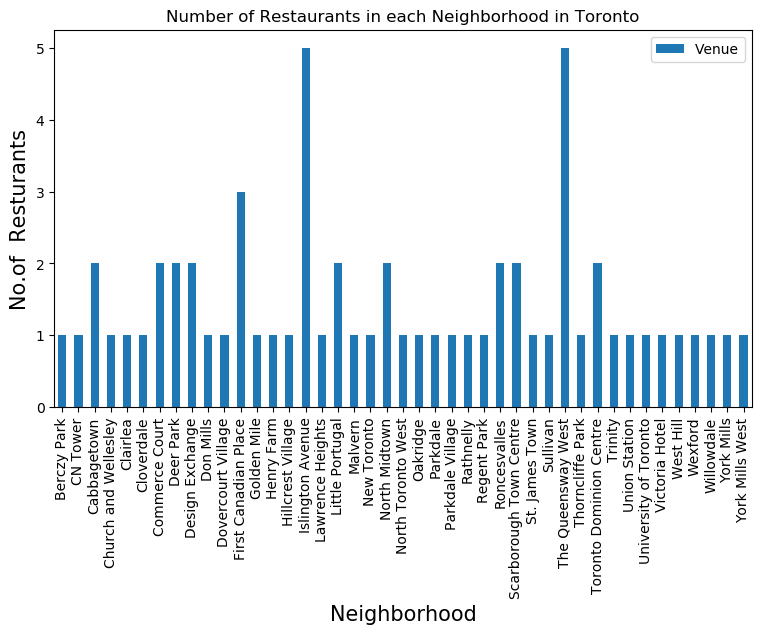

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Restaurants in each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of  Resturants', fontsize=15)
#giving a bar plot
am['Venue'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As we can see, the best neighborhoods to set up this business would be in Islington Avenue or The Queensway West as there are 5 restauarnts in that region, indicating many people would go and grab some ice cream after they eat. Now its up to the person setting up the business to figure out which location would work better for them.